(15, 15)


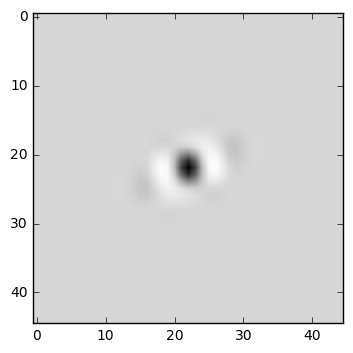

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn

def getRandomGaborParams(size):
    
    theta = np.pi*(2*rand() - 1)
    psi = np.pi*rand()
    sigma = 3*np.abs(randn()) + 10e-3
    lambd = 5*np.abs(randn()) + 10e-3
    gamma = np.pi*rand()
    return {'ksize':size, 'sigma':sigma, 'theta': theta, 'lambd':lambd, 'gamma':gamma, 'psi': psi}
    

# cv2.getGaborKernel(ksize, sigma, theta, lambda, gamma, psi, ktype)
# ksize - size of gabor filter (n, n)
# sigma - standard deviation of the gaussian function
# theta - orientation of the normal to the parallel stripes
# lambda - wavelength of the sunusoidal factor
# gamma - spatial aspect ratio
# psi - phase offset
# ktype - type and range of values that each pixel in the gabor kernel can hold

params = getRandomGaborParams((15,15))
g_kernel = cv2.getGaborKernel(**params)
print(g_kernel.shape)

img = cv2.imread('cat.jpg',0)
filtered_img = cv2.filter2D(img, cv2.CV_32F, g_kernel)

h, w = g_kernel.shape[:2]
g_show = cv2.resize(g_kernel, (3*w, 3*h), interpolation=cv2.INTER_CUBIC)
plt.imshow(g_show, cmap='Greys')
plt.show()

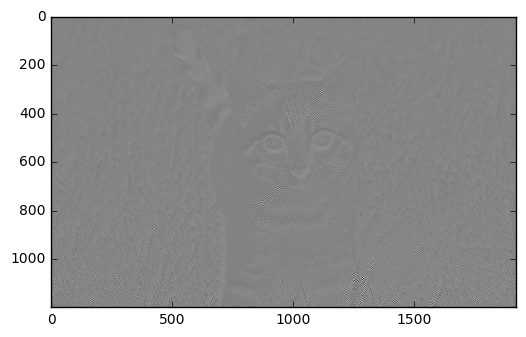

In [6]:
plt.imshow(filtered_img, cmap='Greys')
plt.show()

In [149]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch


class Net(nn.Module):
    def __init__(self, size):
        super(Net, self).__init__()
        
        #self.fc1 = nn.Linear(1, 5, bias=False)
        #self.fc1.weight.requires_grad = False
        self.fc2 = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, 100)
        self.fc4 = nn.Linear(100,size[0]*size[1])
        self.fc5 = nn.Linear(size[0]*size[1], size[0]*size[1])

    def forward(self, x):
        x = torch.FloatTensor(x).squeeze().to(device)
        #self.fc1.weight = torch.nn.Parameter(torch.FloatTensor(params))
        #x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

device = torch.device("cuda")
net = Net(size = [15,15]).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [150]:
for epoch in range(100):  # loop over the dataset multiple times

    params = getRandomGaborParams((15,15))
    g_kernel = cv2.getGaborKernel(**params)
    inputs = [[params['gamma']], [params['lambd']], [params['psi']], [params['sigma']], [params['theta']]]
    
    GT_kernel = torch.FloatTensor(g_kernel.reshape(15*15)).to(device)
    running_loss = 0.0
    
    for tr in range(1000):
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, GT_kernel)
        loss.backward()
        optimizer.step()

In [168]:
params = getRandomGaborParams((15,15))
g_kernel = cv2.getGaborKernel(**params)
inputs = [[params['gamma']], [params['lambd']], [params['psi']], [params['sigma']], [params['theta']]]
GT_kernel = torch.FloatTensor(g_kernel.reshape(15*15))

In [171]:
params = getRandomGaborParams((15,15))
g_kernel = cv2.getGaborKernel(**params)
h, w = g_kernel.shape[:2]
inputs = [[params['gamma']], [params['lambd']], [params['psi']], [params['sigma']], [params['theta']]]
print(inputs)

[[2.954446394427958], [2.86852986713953], [2.5761804109217548], [3.4040528961243424], [-0.5414525660230018]]


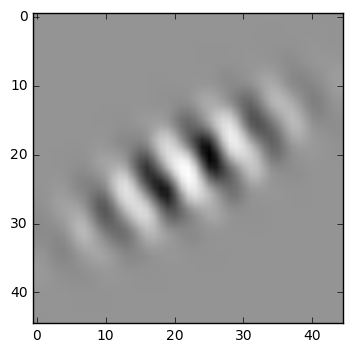

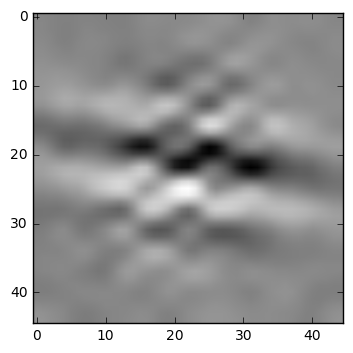

In [172]:
pred = net(inputs).cpu().detach().numpy().reshape(15,15)
#print(net.fc1.weight)

g_show = cv2.resize(g_kernel, (3*w, 3*h), interpolation=cv2.INTER_CUBIC)
plt.imshow(g_show, cmap='Greys')
plt.show()

pred_show = cv2.resize(pred, (3*w, 3*h), interpolation=cv2.INTER_CUBIC)
plt.imshow(pred_show, cmap='Greys')
plt.show()

## My Gabor filter implementation

 Parameters
    ----------
    frequency : float
        Spatial frequency of the harmonic function. Specified in pixels.
    theta : float, optional
        Orientation in radians. If 0, the harmonic is in the x-direction.
    bandwidth : float, optional
        The bandwidth captured by the filter. For fixed bandwidth, `sigma_x`
        and `sigma_y` will decrease with increasing frequency. This value is
        ignored if `sigma_x` and `sigma_y` are set by the user.
    sigma_x, sigma_y : float, optional
        Standard deviation in x- and y-directions. These directions apply to
        the kernel *before* rotation. If `theta = pi/2`, then the kernel is
        rotated 90 degrees so that `sigma_x` controls the *vertical* direction.
    n_stds : scalar, optional
        The linear size of the kernel is n_stds (3 by default) standard
        deviations
    offset : float, optional
        Phase offset of harmonic function in radians.

In [56]:
def myGaborKernel(size = 9, frequency = 1, theta=0, sigma_x=5, sigma_y=5, psi=0):

    x0 = np.ceil(max(size/2, 1))
    y0 = np.ceil(max(size/2, 1))
    print(x0,y0)
    y, x = np.mgrid[-y0+1:y0, -x0+1:x0]

    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)

    g = np.zeros(y.shape, dtype=np.complex)
    g[:] = np.exp(-0.5 * (rotx ** 2 / sigma_x ** 2 + roty ** 2 / sigma_y ** 2))
    #g /= 2 * np.pi * sigma_x * sigma_y
    g *= np.exp(1j * (2 * np.pi * frequency * rotx + psi))
    
    return g

C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


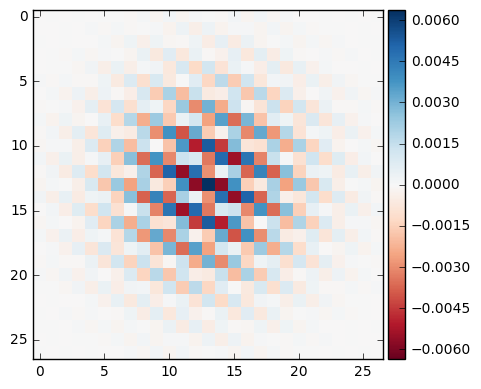

In [15]:
>>> from skimage.filters import gabor_kernel
>>> from skimage import io
>>> from matplotlib import pyplot as plt  # doctest: +SKIP
>>> gk = gabor_kernel(frequency=0.8, sigma_x = 5, sigma_y = 5, theta=1)
>>> plt.figure()        # doctest: +SKIP
>>> io.imshow(gk.real)  # doctest: +SKIP
>>> io.show()           # doctest: +SKIP

In [51]:
gk.shape

(27, 27)

14.0 14.0


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


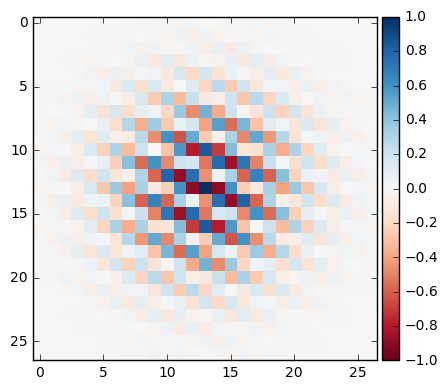

In [57]:
gkm = myGaborKernel(frequency=0.8, sigma_x = 5, sigma_y = 5, theta=1, size = 27)
plt.figure()        # doctest: +SKIP
io.imshow(gkm.real)  # doctest: +SKIP
io.show()

In [55]:
gkm.shape

(27, 27)

In [64]:
np.mgrid[-2:3, -2:3]

array([[[-2, -2, -2, -2, -2],
        [-1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1],
        [ 2,  2,  2,  2,  2]],

       [[-2, -1,  0,  1,  2],
        [-2, -1,  0,  1,  2],
        [-2, -1,  0,  1,  2],
        [-2, -1,  0,  1,  2],
        [-2, -1,  0,  1,  2]]])

## torch implementation

In [59]:
import torch.nn as nn
import torch
from torch.autograd import Variable

In [95]:
import math
import torch
from torch.nn.parameter import Parameter
from .. import functional as F
from .module import Module
from .utils import _single, _pair, _tripleimport math
import torch
from torch.nn.parameter import Parameter
from .. import functional as F
from .module import Module
from .utils import _single, _pair, _triple

class MyGabor(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        
        self.sigma_x = nn.Parameter(torch.ones(in_channels*out_channels))
        self.sigma_y = nn.Parameter(torch.ones(in_channels*out_channels))
        self.freq = nn.Parameter(torch.ones(in_channels*out_channels))
        self.theta = nn.Parameter(torch.zeros(in_channels*out_channels))
        self.psi = nn.Parameter(torch.zeros(in_channels*out_channels))
        
        super(MyGabor, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias)

    def forward(self, input):
        
        x0 = torch.ceil(self.kernel_size[0]/2)
        y0 = torch.ceil(self.kernel_size[1]/2)
        
        for i in range(self.in_channels):
            for j in range(self.out_channels):
                y, x = torch.meshgrid([torch.arange(-y0+1,y0), torch.arange(-x0+1,x0)])
                
                sigma_x = self.sigma_x[i*j].expand_as(y)
                sigma_y = self.sigma_y[i*j].expand_as(y)
                freq = self.freq[i*j].expand_as(y)
                theta = self.theta[i*j].expand_as(y)
                psi = self.psi[i*j].expand_as(y)
                
                rotx = x * torch.cos(theta) + y * torch.sin(theta)
                roty = -x * torch.sin(theta) + y * torch.cos(theta) 
                g = torch.zeros(y.shape)
                g[:] = torch.exp(-0.5 * (rotx ** 2 / sigma_x ** 2 + roty ** 2 / sigma_y ** 2))
                g *= np.cos(2 * np.pi * freq * rotx + psi)
        
                self.weight[j,i] = g
            
        return F.conv2d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

NameError: name 'Gaussian' is not defined

In [ ]:
module = MyGabor()
x = Variable(torch.randn(20))
out = module(x)
loss = loss_fn(out)
loss.backward()

In [92]:
sigma_x = nn.Parameter(torch.ones(2*2))

In [94]:
for i in range(2):
    for j in range(2):
        print(sigma_x[i*j])

tensor(1., grad_fn=<SelectBackward>)
tensor(1., grad_fn=<SelectBackward>)
tensor(1., grad_fn=<SelectBackward>)
tensor(1., grad_fn=<SelectBackward>)


In [89]:
l = nn.Conv2d(1,3, (3,3))

In [90]:
l.weight.shape

torch.Size([3, 1, 3, 3])

In [91]:
y.shape

torch.Size([5, 5])